## Notebook for 1D BDT scan and calculating FOMs in Bd2psi2SKS on data


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/chasenberg/repos/')
import os
import sys
import ROOT
from ROOT import TFile, TH1D, TH2D, TCanvas, gStyle, TLine, TTree
from ROOT import (RooArgSet, RooRealVar, RooDataSet, RooPlot, RooFit, RooStats, RooArgList)
import root_pandas as rp
import root_numpy as ry 

import math
import itertools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from root_pandas import read_root
import pandas as pd

sys.path.append('/home/vmueller/repos')
from dopy.doroot.root_utils import read_roodataset_from_tree, plot_pulls
from dopy.doplot.plotting import Plotter, Plot                

In [2]:

from ROOT import RooRealVar, RooExponential, RooExtendPdf, RooAddPdf, RooArgList, RooGaussian
from ROOT import RooFormulaVar
from ROOT import gSystem
gSystem.Load('libRooFit.so')
gSystem.Load('/home/chasenberg/repos/dopy/dolib/CustomShapes/libKll')
from ROOT import RooIpatia2

### Read ROOT file

In [3]:
dataset_file_name = '/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/Bd2JpsiKS_pv_selected.root'

In [4]:
branches = [
            'B0_FitPVConst_tau_flat',
            'B0_FitPVConst_tauErr_flat',
            'B0_TRUETAU',
            'B0_FitPVConst_MinIPCHI2anyPV_flat',
            'idxRunNumber',
            'idxEventNumber',    
            'idxRandom',
            'idxPV',
            'Delta_TAU',
            'BDTresponse_wrongPV'
            ]

In [5]:
tree_mc = 'Bd2JpsiKS'
signal_dataframe_wrongPV  = rp.read_root(dataset_file_name,key=tree_mc,columns=branches, flatten=False)
signal_dataframe_wrongPV  = signal_dataframe_wrongPV.replace([np.inf, -np.inf], np.nan)
signal_dataframe_wrongPV  = signal_dataframe_wrongPV.dropna()

In [6]:
#columns=branches
signal_dataframe_wrongPV.columns

Index(['B0_FitPVConst_tau_flat', 'B0_FitPVConst_tauErr_flat', 'B0_TRUETAU',
       'B0_FitPVConst_MinIPCHI2anyPV_flat', 'idxRunNumber', 'idxEventNumber',
       'idxRandom', 'idxPV', 'Delta_TAU', 'BDTresponse_wrongPV'],
      dtype='object')

In [7]:
len(signal_dataframe_wrongPV['BDTresponse_wrongPV'])

501573

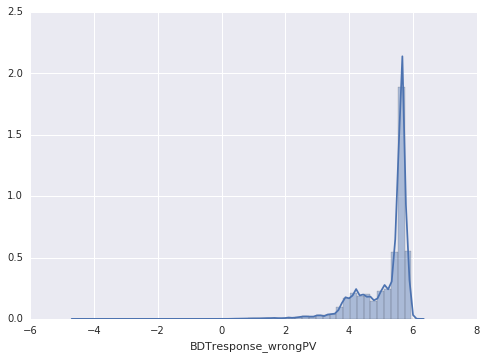

In [8]:
import seaborn as sns
sns.distplot(signal_dataframe_wrongPV['BDTresponse_wrongPV'])

### Function to calculate the FOMs

### Configure  and define cuts 

In [9]:
subdir = '/home/chasenberg/plots/wrongpv_cuttuning'
plot_dir    = os.path.join(subdir, 'plots')
results_dir = os.path.join(subdir, 'results')
plot_file   = os.path.join(plot_dir, 'all_plots.pdf')


if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

cuttype = 'BDTresponse_wrongPV' 

minimum = signal_dataframe_wrongPV['BDTresponse_wrongPV'].min()
maximum = signal_dataframe_wrongPV['BDTresponse_wrongPV'].max()
#cuts_1 = np.linspace(minimum,,5)
#cuts_2 = np.linspace(3.5,3.85,10) #(0,20,10)    #(0,0.001,10)
cuts = np.linspace(3.5,3.85,40)
#cuts = cuts.append(minimum)
#cuts = [-0.05]
cuts_for_which_to_store_sdata = []   

num_sig = []
num_bkg = []
num_all = []

cut_to_performance = {} 
cut_to_shape = {}

perform_fit = True
do_splot    = True
postfix = ''
final_params_file = None
oldParameters = None
final_model = None

In [10]:
eff = signal_dataframe_wrongPV.query('BDTresponse_wrongPV>0').shape[0] / signal_dataframe_wrongPV.shape[0] 
print(eff)

0.9998763888805817


In [11]:
cuts

array([ 3.5       ,  3.50897436,  3.51794872,  3.52692308,  3.53589744,
        3.54487179,  3.55384615,  3.56282051,  3.57179487,  3.58076923,
        3.58974359,  3.59871795,  3.60769231,  3.61666667,  3.62564103,
        3.63461538,  3.64358974,  3.6525641 ,  3.66153846,  3.67051282,
        3.67948718,  3.68846154,  3.6974359 ,  3.70641026,  3.71538462,
        3.72435897,  3.73333333,  3.74230769,  3.75128205,  3.76025641,
        3.76923077,  3.77820513,  3.78717949,  3.79615385,  3.80512821,
        3.81410256,  3.82307692,  3.83205128,  3.84102564,  3.85      ])

In [12]:
'''def calculate_foms(df_random,df_bestpv): 
    import math
    

    delta_m = 5065 
    S = 0.691 #sin2beta value (average from HFAG)
    
    dilution_bdt_bestpv = 0
    dilution_bdt_random = 0
    

    
    tagomega = np.array(df_bestpv['B0_TAGOMEGA_OS'])
    tag1 = np.array(df_bestpv['B0_TAGDECISION_OS'])
    time = np.array(df_bestpv['B0_FitPVConst_tau_flat']) 
    error = np.absolute(np.array(df_bestpv['Delta_TAU']))
    
    tagomega_random = np.array(df_random['B0_TAGOMEGA_OS'])
    tag1_random = np.array(df_random['B0_TAGDECISION_OS'])
    time_random = np.array(df_random['B0_FitPVConst_tau_flat']) 
    error_random = np.absolute(np.array(df_random['Delta_TAU']))
    
    #Calculate dilution for best pv selection
    range_df_bestpv = df_bestpv.shape[0]   
    for i in range(range_df_bestpv):
        timeerror           =  error[i]     
        dilution_bdt_bestpv = math.exp(-(delta_m*timeerror)**2)
        dilution_bdt_bestpv += dilution_bdt_bestpv

    #timeerror_dilution_theory = math.exp(-(delta_m*cut)**2)
    dilution_bdt_bestpv     /= range_df_bestpv
    efficiency_bdt_bestpv   = range_df_bestpv /sig_yields_init
    

    #Calcutlate dilution for random selection
    efficiency_bdt_random   = df_random.shape[0]  / sig_yields_init
    
    print("The efficiency_bdt_random of the cut is:")
    print(efficiency_bdt_random)

    for i in range(df_random.shape[0]):
        timeerror_random    =  error_random[i]
        dilution_bdt_random   = math.exp(-(delta_m*timeerror_random)**2)
        dilution_bdt_random   += dilution_bdt_random
        
    dilution_bdt_random /= df_random.shape[0]  
    
    
    fomname_to_value = {
        'dilution_bdt_bestpv'   : dilution_bdt_bestpv,
        'efficiency_bdt_bestpv' : efficiency_bdt_bestpv,
         #'timeerror_dilution_theory': timeerror_dilution_theory,
        'dilution_bdt_random'  : dilution_bdt_random,
        'efficiency_bdt_random'   : efficiency_bdt_random
    }
    return fomname_to_value'''

'def calculate_foms(df_random,df_bestpv): \n    import math\n    \n\n    delta_m = 5065 \n    S = 0.691 #sin2beta value (average from HFAG)\n    \n    dilution_bdt_bestpv = 0\n    dilution_bdt_random = 0\n    \n\n    \n    tagomega = np.array(df_bestpv[\'B0_TAGOMEGA_OS\'])\n    tag1 = np.array(df_bestpv[\'B0_TAGDECISION_OS\'])\n    time = np.array(df_bestpv[\'B0_FitPVConst_tau_flat\']) \n    error = np.absolute(np.array(df_bestpv[\'Delta_TAU\']))\n    \n    tagomega_random = np.array(df_random[\'B0_TAGOMEGA_OS\'])\n    tag1_random = np.array(df_random[\'B0_TAGDECISION_OS\'])\n    time_random = np.array(df_random[\'B0_FitPVConst_tau_flat\']) \n    error_random = np.absolute(np.array(df_random[\'Delta_TAU\']))\n    \n    #Calculate dilution for best pv selection\n    range_df_bestpv = df_bestpv.shape[0]   \n    for i in range(range_df_bestpv):\n        timeerror           =  error[i]     \n        dilution_bdt_bestpv = math.exp(-(delta_m*timeerror)**2)\n        dilution_bdt_bestpv += dil

### Calculate FOM

In [13]:
def calculate_foms(data_fit_cut,best_pv): 
    import math
    
    signal_sum    = 0
    cbkg_sum      = 0
    signal_sumw2  = 0
    signal_sum_wrong    = 0
    cbkg_sum_wrong       = 0
    signal_sumw2_wrong   = 0
    
    delta_m = 5065 
    S = 0.691 #sin2beta value (average from HFAG)
    
    dilution_bdt_bestpv = 0
    dilution_bdt_random = 0
    

    time = np.array(best_pv['B0_FitPVConst_tau_flat']) 
    error = np.absolute(np.array(best_pv['Delta_TAU']))
   
    time_wrong = np.array(data_fit_cut['B0_FitPVConst_tau_flat']) 
    error_wrong = np.absolute(np.array(data_fit_cut['Delta_TAU']))

    #calculate dilution and efficiency for best PV selection 
    efficiency_bdt_bestpv = best_pv.shape[0]  / sig_yields_init
    
    for i in range(best_pv.shape[0]):
        signal_weight =  1 
        timeerror     =  error[i]        
        signal_sum    += signal_weight
        timeerror_dilution = math.exp(-(delta_m*timeerror)**2)
        dilution_bdt_bestpv    += timeerror_dilution
    
    dilution_bdt_bestpv /= signal_sum
    bdt_bestpv_poisson = 1 / np.sqrt(best_pv.shape[0])
    
    #Calculate for random selection
    efficiency_bdt_random = data_fit_cut.shape[0]  / sig_yields_init

    for i in range(data_fit_cut.shape[0]):
        signal_weight_wrong =  1 
        timeerror_wrong     =  error_wrong[i]
        signal_sum_wrong    += signal_weight_wrong
        timeerror_dilution_wrong = math.exp(-(delta_m*timeerror_wrong)**2)
        dilution_bdt_random     += timeerror_dilution_wrong *signal_weight_wrong 
        
    dilution_bdt_random /= signal_sum_wrong  
    bdt_random_poisson = 1 / np.sqrt(data_fit_cut.shape[0])

    #Write to dictionary
    fomname_to_value = {
        'dilution_bdt_bestpv'   : dilution_bdt_bestpv,
        'efficiency_bdt_bestpv' : efficiency_bdt_bestpv,
        'bdt_bestpv_poisson'    : bdt_bestpv_poisson,
        'dilution_bdt_random'   : dilution_bdt_random,
        'efficiency_bdt_random' : efficiency_bdt_random,
        'bdt_random_poisson'    : bdt_random_poisson, 
    }
    
    return fomname_to_value

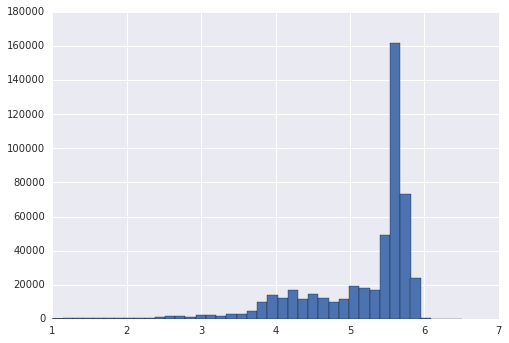

In [14]:
import numpy as np
import matplotlib.pyplot as plt
plt.hist(signal_dataframe_wrongPV['BDTresponse_wrongPV'],40,range=[1,6.5])
plt.savefig("/home/chasenberg/plots/wrong_pv/bdt_output.pdf")

In [15]:
print(str(cuts[0]))

3.5


In [16]:
from ROOT import RooArgList
import subprocess, os
import time
import root_pandas as rp

x=None

cut = str(cuts[0])
data_fit_cut = signal_dataframe_wrongPV.query('BDTresponse_wrongPV>'+cut)
data_fit_cut.to_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim_initial.root',key=tree_mc)
my_env = os.environ.copy()
my_env['PATH'] = '/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/sbin:/home/chasenberg/bin'
my_env['LD_LIBRARY_PATH'] = '/usr/local/lib'
my_env['script'] = '/home/chasenberg/repos/b2cc_sin2beta_run2/notebooks/selection'
my_command = 'source /lhcbsoft/LHCbSoftwareSetup.sh &&' \
        'lb-run DaVinci/v41r2 $BASH -c "' \
        'echo $PATH && ' \
        'source /doosoft/InstallDooSoftware/LoadDooSoftware && CandidateSelectionGrimReaper /fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim_initial.root Bd2JpsiKS /fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim_initial.root Bd2JpsiKS "idxRunNumber""'        
subprocess.Popen([my_command], env=my_env, shell=True)
        
print("Wait for GrimReaper")
time.sleep(120.0)        # pause 5.5 seconds
print("GrimReaper hopefully finished")
print('INFO: Read selected data', flush=True)
data_fit_cut = rp.read_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim_initial.root',key=tree_mc)
sig_yields_init = data_fit_cut.shape[0]

Wait for GrimReaper
GrimReaper hopefully finished
INFO: Read selected data


In [17]:
'''#calculate poisson uncertainty 
test = pd.DataFrame()
poisson_error_arr = []
for cut in cuts:
    cut = str(cut)
    mu = data_fit_cut.query('BDTresponse_wrongPV>'+cut).shape[0]
    print("Yields after the cut:")
    print("---------------------")
    print(mu)
    poisson_error = 1/np.sqrt(mu)
    print(poisson_error)
    poisson_error_arr.append(poisson_error)
    #return(poisson_error_arr)
poisson_error_arr = poisson_error_arr/np.amax(poisson_error_arr)#*min(np.array(ys['TimeresPower']))
error = np.array(poisson_error_arr)
test['error'] = error'''

'#calculate poisson uncertainty \ntest = pd.DataFrame()\npoisson_error_arr = []\nfor cut in cuts:\n    cut = str(cut)\n    mu = data_fit_cut.query(\'BDTresponse_wrongPV>\'+cut).shape[0]\n    print("Yields after the cut:")\n    print("---------------------")\n    print(mu)\n    poisson_error = 1/np.sqrt(mu)\n    print(poisson_error)\n    poisson_error_arr.append(poisson_error)\n    #return(poisson_error_arr)\npoisson_error_arr = poisson_error_arr/np.amax(poisson_error_arr)#*min(np.array(ys[\'TimeresPower\']))\nerror = np.array(poisson_error_arr)\ntest[\'error\'] = error'

In [18]:
for cut in cuts:
    print('INFO: Starting to test cut ' + '{0}>{1}'.format(cuttype,cut), flush=True)
    data_fit_cut = signal_dataframe_wrongPV.query('{0}>{1}'.format(cuttype,cut)) 
    best_pv = signal_dataframe_wrongPV.query('{0}>{1}'.format(cuttype,cut)).query('idxPV==0')
    data_fit_cut.to_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root',key=tree_mc)
    print('INFO: Call CandidateSelectionGrimReaper', flush=True)
    my_env = os.environ.copy()
    my_env['PATH'] = '/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/sbin:/home/chasenberg/bin'
    my_env['LD_LIBRARY_PATH'] = '/usr/local/lib'
    my_env['script'] = '/home/chasenberg/repos/b2cc_sin2beta_run2/notebooks/selection'
    my_command = 'source /lhcbsoft/LHCbSoftwareSetup.sh &&' \
             'lb-run DaVinci/v41r2 $BASH -c "' \
             'echo $PATH && ' \
             'source /doosoft/InstallDooSoftware/LoadDooSoftware && CandidateSelectionGrimReaper /fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root Bd2JpsiKS /fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root Bd2JpsiKS "idxRandom""'                     
    subprocess.Popen([my_command], env=my_env, shell=True)
   # subprocess.call(('bash /home/chasenberg/repos/b2cc_sin2beta_run2/notebooks/selection/random_sel.sh'),shell=True)                      
    print("Wait for GrimReaper")
    time.sleep(150.0)    # pause 5.5 seconds
    print("GrimReaper hopefully finished")
    print('INFO: Read selected data', flush=True)
    data_fit_cut = rp.read_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root',key=tree_mc)
    
    print('INFO: Start Calculation', flush=True)
    #print('INFO: Building Ipatia (signal) + Exp (combinatorics) + Ipatia (bs-component) model for data', flush=True) 
    #final_model = build_mass_model(B0_FitDaughtersConst_M)
    sig_yields_cut = data_fit_cut.shape[0] 
    efficiency = sig_yields_cut / sig_yields_init
    print("The inital number of candidates is:")
    print(sig_yields_init)
    print("----------------------------------")
    print("The number of candidates after the cut is:")
    print(sig_yields_cut)
    print("----------------------------------")
    print("The efficiency of the cut is:")
    print(efficiency)
    cut_to_shape[cut] = {} 
    cut_to_performance[cut] = {}
    
    
    foms = calculate_foms(data_fit_cut,best_pv)
    cut_to_performance[cut].update(foms)
    
    print('INFO: Finish Calculation', flush=True)

INFO: Starting to test cut BDTresponse_wrongPV>3.5
INFO: Call CandidateSelectionGrimReaper
Wait for GrimReaper
GrimReaper hopefully finished
INFO: Read selected data
INFO: Start Calculation
The inital number of candidates is:
482051
----------------------------------
The number of candidates after the cut is:
482051
----------------------------------
The efficiency of the cut is:
1.0
INFO: Finish Calculation
INFO: Starting to test cut BDTresponse_wrongPV>3.508974358974359
INFO: Call CandidateSelectionGrimReaper
Wait for GrimReaper
GrimReaper hopefully finished
INFO: Read selected data
INFO: Start Calculation
The inital number of candidates is:
482051
----------------------------------
The number of candidates after the cut is:
481930
----------------------------------
The efficiency of the cut is:
0.9997489892148341
INFO: Finish Calculation
INFO: Starting to test cut BDTresponse_wrongPV>3.517948717948718
INFO: Call CandidateSelectionGrimReaper
Wait for GrimReaper
GrimReaper hopefully f

In [19]:
import numpy as np

def unpack_cut_dict(cut_dict, normalize=True):
    cuts = np.array(list(cut_dict.keys()))
    cuts.sort()
    
    new_dict = {}
    for cut in cuts:
        parameters_dict = cut_dict[cut]
        for parameter, value in parameters_dict.items():
            if parameter in new_dict:
                new_dict[parameter].append(value)
            else:
                new_dict[parameter] = [value]
    
    for parameter, values in new_dict.items():
        new_dict[parameter] = np.array(values)
        if normalize:
            new_dict[parameter] = values/np.max(np.abs(values))
    
    return cuts, new_dict

x, ys = unpack_cut_dict(cut_to_performance)
for parameter, values in ys.items():
    if "value" in parameter:
        print(values)
        y_errlo = np.array(ys[parameter.replace("_value","_errlo")])
        y_errhi = np.array(ys[parameter.replace("_value","_errhi")])
        y_errors= abs(np.vstack([y_errlo,y_errhi]))
        plt.errorbar(x,values,yerr=y_errors,marker='.',linestyle='', label='sigma')
        plt.xlabel(parameter)
        plotname = parameter + '.pdf'
        singleplot_file = os.path.join(plot_dir, plotname)
        plt.savefig(singleplot_file)
        plt.show()

### Plot FOMs

In [20]:
'''
test['TimeresPower'] = np.array(ys['TimeresPower_bdt'])
test['TimeresPower_poisson'] = test['TimeresPower'] / test['error']
test['TimeresPower_bestPV'] = np.array(ys['TimeresPower_bestPV'])
test['Efficiency'] = np.array(ys['Efficiency'])'''

"\ntest['TimeresPower'] = np.array(ys['TimeresPower_bdt'])\ntest['TimeresPower_poisson'] = test['TimeresPower'] / test['error']\ntest['TimeresPower_bestPV'] = np.array(ys['TimeresPower_bestPV'])\ntest['Efficiency'] = np.array(ys['Efficiency'])"

In [21]:
df_bdt = pd.DataFrame()
df_bdt['dilution_bdt_bestpv'] = np.array(ys['dilution_bdt_bestpv'])
df_bdt['dilution_bdt_random'] = np.array(ys['dilution_bdt_random'])
df_bdt['efficiency_bdt_bestpv'] = np.array(ys['efficiency_bdt_bestpv'])
df_bdt['efficiency_bdt_random'] = np.array(ys['efficiency_bdt_random'])
df_bdt['bdt_random_poisson'] = np.array(ys['bdt_random_poisson'])
df_bdt['bdt_bestpv_poisson'] = np.array(ys['bdt_bestpv_poisson'])
df_bdt['dilution_bdt_random_poisson'] = df_bdt['dilution_bdt_random'] / df_bdt['bdt_random_poisson']
df_bdt['dilution_bdt_bestpv_poisson'] = df_bdt.dilution_bdt_bestpv / df_bdt.bdt_bestpv_poisson

### Get similiar efficiencies for both approaches

#### Import dataframe 

In [22]:
df_minipchi2 = pd.read_csv('/home/chasenberg/plots/csv_data/minipchi2.csv')


In [23]:
df_minipchi2.shape,df_bdt.shape

((40, 9), (40, 8))

### Normalize both dataframes

In [24]:
normalize = True
if normalize==True:    
    params_bdt = list(df_bdt.columns)
    params_minipchi2 = list(df_minipchi2.columns)
    for param in params_bdt:
        param = str(param)
        df_bdt[param] = df_bdt[param] / df_bdt[param].max()
    for param in params_minipchi2:
        param = str(param)
        df_minipchi2[param] = df_minipchi2[param] / df_minipchi2[param].max()

### Merge both dataframes

In [25]:
df_all = pd.concat([df_minipchi2,df_bdt], axis=1)

### Compare BDT approach vs. MinIPCHI2

In [26]:
df_all.dilution_minipchi2_random.min(),df_all.dilution_bdt_random.min()

(0.99535069730050318, 0.99958314682816185)

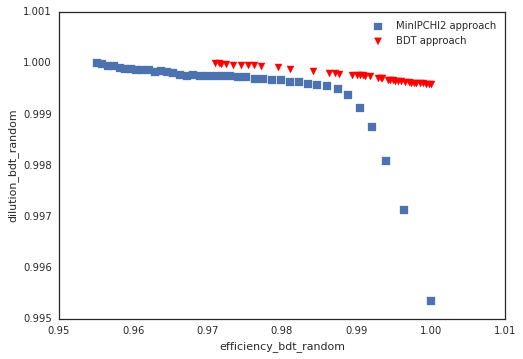

In [27]:
import seaborn as sns; sns.set_style('white')
plt.title("")
plt.xlabel("")
plt.ylabel("")

plot_3 = sns.regplot(x='efficiency_minipchi2_random', y='dilution_minipchi2_random',data=df_all,marker='s',x_estimator=np.mean,fit_reg=False,label="MinIPCHI2 approach") 
plot_2 = sns.regplot(x='efficiency_bdt_random', y='dilution_bdt_random',data=df_all,x_estimator=np.mean,marker='v',color='red',fit_reg=False,label="BDT approach")
plot_2.legend(loc="best")
plt.savefig("/home/chasenberg/plots/wrong_pv/timres_eff_bdt_vs_chi2.pdf")

### Weight with Poisson error

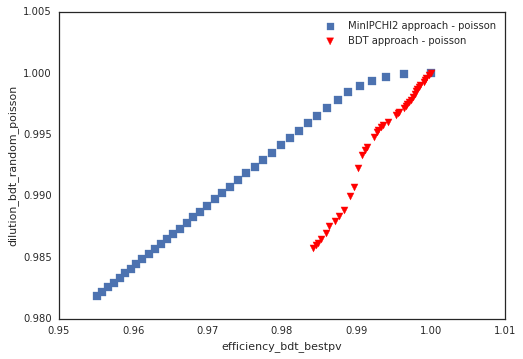

In [28]:
plt.title("")
plt.xlabel("")
plt.ylabel("")

#plot_1 = sns.regplot(x='Efficiency', y='TimeresPower',data=test_cut,x_estimator=np.mean,fit_reg=True,label="BDT approach") 
#plot_2 = sns.regplot(x='Efficiency', y='error',data=test_cut,x_estimator=np.mean,fit_reg=True,label="Poisson error")
plot_3 = sns.regplot(x='efficiency_minipchi2_random', y='dilution_minipchi2_random_poisson',data=df_all,marker='s',x_estimator=np.mean,fit_reg=False,label="MinIPCHI2 approach - poisson") 
plot_2 = sns.regplot(x='efficiency_bdt_bestpv', y='dilution_bdt_random_poisson',data=df_all,marker='v',color='red',x_estimator=np.mean,fit_reg=False,label="BDT approach - poisson")

 
plot_2.legend(loc="best")
plt.savefig("/home/chasenberg/plots/wrong_pv/timres_eff_bdt_vs_chi2_poisson.pdf")

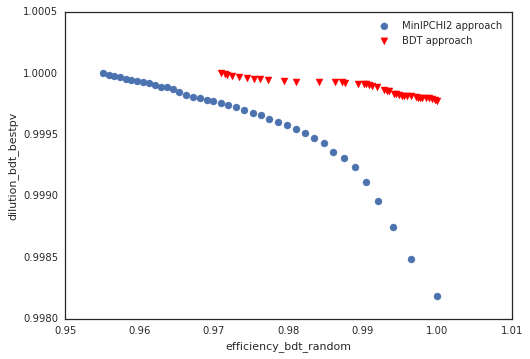

In [29]:
plt.title("")
plt.xlabel("")
plt.ylabel("")

plot_3 = sns.regplot(x='efficiency_minipchi2_random', y='dilution_minipchi2_bestpv',data=df_minipchi2,x_estimator=np.mean,fit_reg=False,label="MinIPCHI2 approach") 
plot_2 = sns.regplot(x='efficiency_bdt_random', y='dilution_bdt_bestpv',data=df_bdt,x_estimator=np.mean,fit_reg=False,marker='v',color='red',label="BDT approach")
plot_2.legend(loc="best")
plt.savefig("/home/chasenberg/plots/wrong_pv/timres_eff_bdt_vs_chi2_bestpv.pdf")

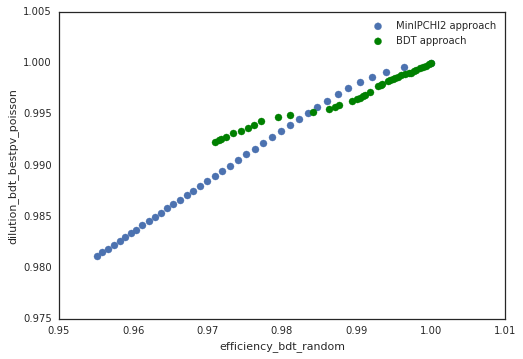

In [30]:
plt.title("")
plt.xlabel("")
plt.ylabel("")

plot_3 = sns.regplot(x='efficiency_minipchi2_random', y='dilution_minipchi2_bestpv_poisson',data=df_minipchi2,x_estimator=np.mean,marker='o',fit_reg=False,label="MinIPCHI2 approach") 
plot_2 = sns.regplot(x='efficiency_bdt_random', y='dilution_bdt_bestpv_poisson',data=df_bdt,x_estimator=np.mean,marker='o',color='green',fit_reg=False,label="BDT approach")
plot_2.legend(loc="best")
plt.savefig("/home/chasenberg/plots/wrong_pv/timres_eff_bdt_vs_chi2_bestpv_poisson.pdf")

### Compare BDT approach vs best PV selection

In [31]:
df_bdt.columns

Index(['dilution_bdt_bestpv', 'dilution_bdt_random', 'efficiency_bdt_bestpv',
       'efficiency_bdt_random', 'bdt_random_poisson', 'bdt_bestpv_poisson',
       'dilution_bdt_random_poisson', 'dilution_bdt_bestpv_poisson'],
      dtype='object')

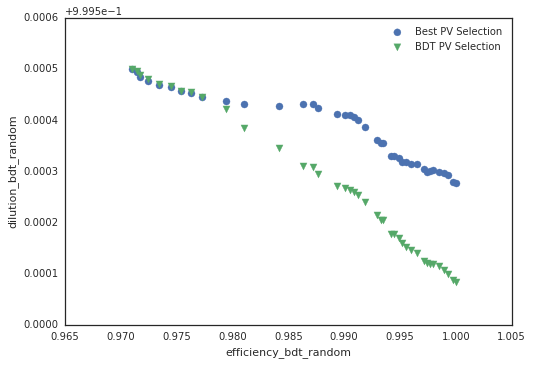

In [32]:
plt.title("")
plt.xlabel("")
plt.ylabel("")

plot_2 = sns.regplot(x='efficiency_bdt_random', y='dilution_bdt_bestpv',data=df_bdt,x_estimator=np.mean,marker='o', fit_reg=False,label='Best PV Selection')
plot_1 = sns.regplot(x='efficiency_bdt_random', y='dilution_bdt_random',data=df_bdt,x_estimator=np.mean,marker='v', fit_reg=False,label='BDT PV Selection')
plot_1.legend(loc="best")
#plot_1.set(xlim=(test['Efficiency'].min(), test['Efficiency'].max()))
#plot_1.set(ylim=(0.9995,1.0001))
plt.savefig("/home/chasenberg/plots/wrong_pv/timres_eff_bdt_bestpv_vs_random.pdf")

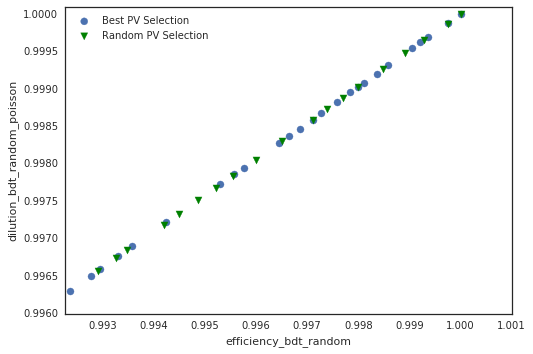

In [53]:
plot_2 = sns.regplot(x='efficiency_bdt_bestpv', y='dilution_bdt_bestpv_poisson',data=df_bdt,x_estimator=np.mean,marker='o', fit_reg=False,label='Best PV Selection')
plot_1 = sns.regplot(x='efficiency_bdt_random', y='dilution_bdt_random_poisson',data=df_bdt,x_estimator=np.mean,marker='v',color='green', fit_reg=False,label='Random PV Selection')
plot_1.legend(loc="upper left")

if df_bdt['dilution_bdt_bestpv_poisson'].min() > df_bdt['dilution_bdt_random_poisson'].min():
    plot_1.set(ylim=(df_bdt['dilution_bdt_bestpv_poisson'].min(), df_bdt['dilution_bdt_random_poisson'].max()+0.01))
else:  
    plot_1.set(ylim=(df_bdt['dilution_bdt_random_poisson'].min(), df_bdt['dilution_bdt_random_poisson'].max()+0.001))
plot_1.set(xlim=(df_bdt['dilution_bdt_bestpv_poisson'].min(), df_bdt['dilution_bdt_bestpv_poisson'].max()+0.001))
plot_1.set(ylim=(0.996, 1.0001))


plt.savefig("/home/chasenberg/plots/wrong_pv/timres_eff_bdt_bestpv_vs_random_poisson.pdf")